# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import straeto
straeto.getBusPositionsFor(["55"])[0]

{'deviceNumber': 144,
 'gpsFix': 2,
 'gpsTime': '180508153927',
 'heading': 175.45,
 'lastStop': 90000015,
 'lat': 64.1207283333333,
 'lon': -21.8989166666667,
 'nextStop': 13001300,
 'pingCode': 6,
 'route': '55-A',
 'routeNumber': '55',
 'speed': 46.38}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

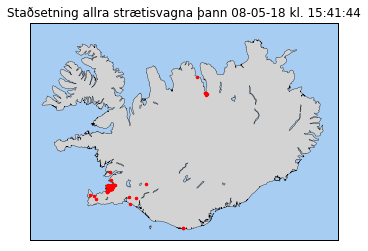

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

map = Basemap(projection='merc', resolution='h', urcrnrlat=66.8, urcrnrlon=-12.9, llcrnrlat=63.2, llcrnrlon=-25)
map.drawcoastlines(linewidth=0.35)
map.fillcontinents(color='lightgrey', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

for bus in straeto.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [89]:
import time
from datetime import datetime as dt
from geopy.distance import vincenty

p_buses = straeto.getAllBusPositions()

p_bdict = dict()
for pb in p_buses:
    p_bdict[pb['deviceNumber']] = {'gpsTime':pb['gpsTime'], 'lat':pb['lat'], 'lon':pb['lon'], 'speed':pb['speed']}

bdict = dict()
while True:
    buses = straeto.getAllBusPositions()

    for pb in p_buses:
        did = pb['deviceNumber']
        b = next(b for b in buses if b['deviceNumber'] == did)
        if b['gpsTime'] != pb['gpsTime'] and b['lat'] != pb['lat'] and b['lon'] != pb['lon']:
            bdict[did] = {'gpsTime':pb['gpsTime'], 'lat':pb['lat'], 'lon':pb['lon'], 'speed':pb['speed']}
    
    if (1/2)*len(p_bdict) < len(bdict):
        break
    time.sleep(1)

print(bdict[16])

{'gpsTime': '180509002319', 'lat': 64.1223516666667, 'lon': -21.8745166666667, 'speed': 21.33}


In [ ]:
p_buses = straeto.getBusPositionsFor(["1"]); buses = p_buses
while buses[0]['gpsTime'] == p_buses[0]['gpsTime']:
    buses = straeto.getBusPositionsFor(["1"])
    time.sleep(1)

bus = buses[0]; p_bus = p_buses[0]
t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
delta_t = (t_1-t_2).total_seconds()
delta_s = vincenty((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

kmh = (delta_s/delta_t)*3600
avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

print('k =', kmh/avg_speed)

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [ ]:
!ls